# Popularity Recommendation

In [1]:
import pandas as pd
import numpy as np
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
all_order_train = pd.read_pickle('../all_order_train.pkl')
all_order_test = pd.read_pickle('../all_order_test.pkl')
print(all_order_train.shape, all_order_test.shape)

all_order_train.head()

(33720820, 12) (98286, 12)


,order_id,user_id,order_number,order_hour_of_day,product_id,purchase_date,merchant,product_name,price,aisle,department,week_number
0,2539329,1,1,8,196,2019-02-13,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,7
1,2231262,31,17,11,196,2019-03-10,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
2,3058369,195,34,10,196,2019-02-25,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,9
3,2257155,951,3,20,196,2019-03-09,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10
4,1121647,992,7,10,196,2019-03-08,L&M Markets (Hometown Grocers Co-op),Soda,3.08,soft drinks,beverages,10


## Products Popularity & Value

The purpose of this step is to generate the popularity and value for each product.

* For each product there are 3 values:
  * `popularity = total purchase amount in a specific period`
    * Purchase frequency is 1 for both daily and weekly frequency. So for this date, I'm using total amount instead of frequency to calculate the popularity.
  * `total_popularity = latest_popularity * weight_latest + earlier_popularity * weight_earlier`
    * `weight_latest` is the weight for the latest period, such as latest 2 weeks
    * `weight_earlier` is the weight for the rest of the earlier period
    * weight_latest should be higher than weight_earlier, since the assumption is the forecast is closer to its latest previous period.
  * `product_value = unit_price * latest_period_purchase / latest_period`
    * `latest_period` is latest N weeks, such as latest 2 weeks. Same value as latest period used in `total_popularity`
* Sort all the products by total_popularity, product_value descending order
* For the target merchant who do not have the top N products, recommend these

### Get Product Popularity

In [3]:
popularity_df = all_order_train[['product_id', 'order_id', 'week_number']].drop_duplicates()\
                                                  .groupby(['product_id', 'week_number'], as_index=False)['order_id']\
                                                  .agg('count').reset_index()\
                                                  .sort_values(by=['product_id', 'week_number'])
popularity_df.head()

,index,product_id,week_number,order_id
0,0,1,7,178
1,1,1,8,332
2,2,1,9,185
3,3,1,10,246
4,4,1,11,219


In [4]:
popularity_df.drop('index', inplace=True, axis=1)
popularity_df = popularity_df.rename(index=str, columns={'order_id': 'weekly_popularity'})

popularity_df.head()

,product_id,week_number,weekly_popularity
0,1,7,178
1,1,8,332
2,1,9,185
3,1,10,246
4,1,11,219


In [5]:
def get_total_popularity(latest_weeks, latest_weight, earlier_weight, popularity_df):
    latest_popularity_df = popularity_df.groupby('product_id')\
                                    .apply(lambda x: x.nlargest(latest_weeks, 'week_number'))\
                                    .reset_index(drop=True)  

    earlier_popularity_df = popularity_df.groupby('product_id')\
                                    .apply(lambda x: x.nsmallest(x['week_number'].nunique()-latest_weeks, 'week_number'))\
                                    .reset_index(drop=True) 
    
    latest_popularity_agg = latest_popularity_df.groupby('product_id', 
                                                     as_index=False)['weekly_popularity'].agg(['sum']).reset_index()
    latest_popularity_agg = latest_popularity_agg.rename(index=str, columns={'sum': 'latest_popularity'})
    earlier_popularity_agg = earlier_popularity_df.groupby('product_id', 
                                                         as_index=False)['weekly_popularity'].agg(['sum']).reset_index()
    earlier_popularity_agg = earlier_popularity_agg.rename(index=str, columns={'sum': 'earlier_popularity'})
    
    popularity_agg = latest_popularity_agg.merge(earlier_popularity_agg, on='product_id')
    popularity_agg['total_popularity'] = popularity_agg['latest_popularity']*latest_weight + popularity_agg['earlier_popularity']*earlier_weight

    return popularity_agg

In [6]:
popularity_agg = get_total_popularity(latest_weeks=2, latest_weight=0.7, earlier_weight=0.01, popularity_df=popularity_df)
print(popularity_agg.shape)

popularity_agg.head()

(49019, 4)


,product_id,latest_popularity,earlier_popularity,total_popularity
0,1,8,1909,24.69
1,2,3,91,3.01
2,3,5,278,6.28
3,4,8,342,9.02
4,5,2,14,1.54


In [8]:
popularity_agg['product_id'].nunique()

49019

### Get Product Value

The value here is calculated for latets_period.
Latest period should be the same as forecasting moving window.

In [9]:
def get_product_value(latest_weeks, df):
    latest_df = df[['product_id', 'week_number']].drop_duplicates().groupby('product_id')\
                                    .apply(lambda x: x.nlargest(latest_weeks, 'week_number'))\
                                    .reset_index(drop=True) 
    
    value_df = pd.merge(df[['product_id', 'price', 'order_id', 'week_number']], latest_df, how='inner',
                                                        left_on=['product_id', 'week_number'],
                                                        right_on=['product_id', 'week_number'])
    
    latest_value_df = value_df.groupby(['product_id', 'price'], as_index=False)['order_id']\
                              .agg({'order_id': 'count'})

    latest_value_df['product_value'] = latest_value_df['price'] * latest_value_df['order_id']/latest_weeks
    
    return latest_value_df

In [10]:
latest_value_df = get_product_value(latest_weeks=2, df=all_order_train)
print(latest_value_df.shape)

latest_value_df.head()

(49685, 4)


,product_id,price,order_id,product_value
0,1,13.33,8,53.320
1,2,6.57,3,9.855
2,3,7.76,5,19.400
3,4,13.76,8,55.040
4,5,6.21,2,6.210


In [11]:
latest_value_df['product_id'].nunique()

49685

### Get Product Average Daily Sales

Based on the special situation in this data, the average daily sales might be the same as product price.

In [12]:
purchase_ct_df = all_order_train[['product_id', 'order_id', 'purchase_date']].astype('str').drop_duplicates()\
                                                  .groupby(['product_id'], as_index=False)[['order_id', 'purchase_date']]\
                                                  .agg({'order_id': 'count', 'purchase_date': 'count'}).reset_index()

purchase_ct_df.head()

,index,product_id,order_id,purchase_date
0,0,1,1917,1917
1,1,10,2686,2686
2,2,100,457,457
3,3,1000,2688,2688
4,4,10000,13,13


In [14]:
print(max(purchase_ct_df['purchase_date']/purchase_ct_df['order_id']), min(purchase_ct_df['purchase_date']/purchase_ct_df['order_id']))

1.0 1.0


In [20]:
product_values = popularity_agg[['product_id', 'total_popularity']].merge(latest_value_df[['product_id', 'product_value', 'price']],
                                                                          on='product_id')
print(product_values.shape, product_values['product_id'].nunique())
product_values = product_values.rename(index=str, columns={'price': 'avg_daily_sales'})

product_values.head()

(49019, 4) 49019


,product_id,total_popularity,product_value,avg_daily_sales
0,1,24.69,53.320,13.33
1,2,3.01,9.855,6.57
2,3,6.28,19.400,7.76
3,4,9.02,55.040,13.76
4,5,1.54,6.210,6.21


In [24]:
product_values = product_values.sort_values(by=['total_popularity', 'product_value'], ascending=[False, False])

product_values.head()

,product_id,total_popularity,product_value,avg_daily_sales
24517,24852,6935.67,31742.000,21.52
12984,13176,5385.83,12622.375,12.05
20846,21137,3708.33,6519.100,9.38
21602,21903,3537.39,15351.590,20.62
46574,47209,3003.98,6164.910,10.62


In [18]:
product_values = product_values.merge(all_order_train[['product_id', 'product_name']].drop_duplicates(), on='product_id')
print(product_values.shape)

product_values.head()

(49019, 5)


,product_id,total_popularity,product_value,avg_daily_sales,product_name
0,24852,6935.67,31742.000,21.52,Banana
1,13176,5385.83,12622.375,12.05,Bag of Organic Bananas
2,21137,3708.33,6519.100,9.38,Organic Strawberries
3,21903,3537.39,15351.590,20.62,Organic Baby Spinach
4,47209,3003.98,6164.910,10.62,Organic Hass Avocado


In [19]:
product_values.to_pickle('product_values.pkl')

## Sample Merchants Recommendation

* Recommend top 10 products cannot be found in a merchant's transactions.
* Forecast the sales in the next N weeks after adding each recommended product.

* Notes
  * Product value is the latest value, there should be `latest_period = forecasting moving window size`

In [20]:
sample_merchant_df1 = all_order_train.loc[all_order_train['merchant']=='49th Parallel Grocery']
print(sample_merchant_df1.shape)

sample_merchant_df1.head()

(1365312, 12)


,order_id,user_id,order_number,order_hour_of_day,product_id,purchase_date,merchant,product_name,price,aisle,department,week_number
705698,2452257,7,20,9,47272,2019-04-04,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,14
705699,1867977,2850,19,10,47272,2019-03-14,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,11
705700,2879669,18719,1,23,47272,2019-02-23,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,8
705701,252427,38924,5,13,47272,2019-03-31,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,13
705702,1252985,55521,6,16,47272,2019-02-23,49th Parallel Grocery,Antioxidant Infusions Beverage Malawi Mango,2.03,refrigerated,beverages,8


In [21]:
sample_products_set1 = sample_merchant_df1['product_id'].unique()
print(len(sample_products_set1), len(sample_merchant_df1['department'].unique()))

recommended_products = product_values.loc[~product_values['product_id'].isin(sample_products_set1)]\
                                     .sort_values(by=['total_popularity', 'product_value'], 
                                                  ascending=[False, False]).head(n=10).reset_index(drop=True)
recommended_products

37655 21


,product_id,total_popularity,product_value,avg_daily_sales,product_name
0,4585,21.11,83.250,5.55,Hot and Spicy Crispy Pickled Beans
1,14609,17.60,190.000,15.20,Soy Powder Infant Formula
2,31418,16.49,42.320,3.68,Sparking Water
3,36088,14.90,101.955,9.71,Cranberry Ginger Kombucha
4,42926,14.81,74.130,7.06,Organic Rice Protein Plain
5,2465,13.44,81.890,8.62,Peanut Butter Formula Miniature Dog Treats
6,36674,13.07,363.690,40.41,Great White Beer
7,7957,11.61,24.320,3.04,Decaf-Zero Green Tea With Ginseng
8,8067,11.30,26.960,3.37,Thirst Quencher Tropical Cooler
9,37539,11.27,99.360,12.42,Brown Butter Plum


In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# the logger here is to remove the warnings about plotly
import logging
logger = logging.getLogger('fbprophet.plot')
logger.setLevel(logging.CRITICAL)
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [49]:
sample_train_df1 = pd.read_pickle('../sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('../sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

(100, 2) (14, 2)


In [58]:
train1_col = sample_train_df1['purchase_amount']
test1_col = sample_test_df1['purchase_amount']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean()

ts_moving_avg_train1.head(n=10)

purchase_date
2019-02-11          NaN
2019-02-12          NaN
2019-02-13          NaN
2019-02-14    11.336649
2019-02-15    11.574900
2019-02-16    11.823810
2019-02-17    12.072987
2019-02-18    12.329429
2019-02-19    12.547873
2019-02-20    12.668333
Name: purchase_amount, dtype: float64

In [51]:
ts_ma_train1 = pd.DataFrame(ts_moving_avg_train1.copy())
ts_ma_train1['ds'] = ts_ma_train1.index
ts_ma_train1['y'] = ts_moving_avg_train1.values
ts_ma_train1.drop(['purchase_amount'], inplace=True, axis=1)
print(ts_ma_train1.shape)

ts_ma_test1 = pd.DataFrame(ts_moving_avg_test1.copy())
ts_ma_test1['ds'] = ts_ma_test1.index
ts_ma_test1['y'] = ts_moving_avg_test1.values
ts_ma_test1.drop(['purchase_amount'], inplace=True, axis=1)
print(ts_ma_test1.shape)

ts_ma_train1.head()

(100, 2)
(14, 2)


,ds,y
purchase_date,,
2019-02-11,2019-02-11,NaN
2019-02-12,2019-02-12,NaN
2019-02-13,2019-02-13,NaN
2019-02-14,2019-02-14,11.336649
2019-02-15,2019-02-15,11.574900


In [54]:
latest_period = 14
forecast_period = 7

train = ts_ma_train1.tail(n=latest_period)
test = ts_ma_test1.head(n=forecast_period)

print(train.shape, test.shape)

train.head()

(14, 2) (7, 2)


,ds,y
purchase_date,,
2019-05-08,2019-05-08,10.493818
2019-05-09,2019-05-09,10.377655
2019-05-10,2019-05-10,10.238874
2019-05-11,2019-05-11,10.085350
2019-05-12,2019-05-12,9.989850


In [56]:
prophet_model = Prophet(daily_seasonality = True, yearly_seasonality=False, weekly_seasonality=False,
                            seasonality_mode = 'multiplicative', n_changepoints=5,
                            changepoint_prior_scale=0.05, seasonality_prior_scale=0.1)
prophet_model.fit(train)
    
periods = len(test.index)
future = prophet_model.make_future_dataframe(periods=periods)
forecast = prophet_model.predict(future)

print(train.shape, test.shape, forecast.shape)
all_ts = train.append(test).dropna()
selected_forecast = forecast.loc[forecast['ds'].isin(all_ts.index)]
rmse = round(sqrt(mean_squared_error(all_ts['y'].values, selected_forecast['yhat'].values)), 4)
print(rmse)

forecast.head()

(14, 2) (7, 2) (21, 16)
0.0391


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-05-08,9.590014,10.471568,10.521030,9.590014,9.590014,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,10.495194
1,2019-05-09,9.472009,10.340208,10.391694,9.472009,9.472009,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,10.366051
2,2019-05-10,9.354004,10.212395,10.263301,9.354004,9.354004,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,10.236907
3,2019-05-11,9.237804,10.083354,10.134498,9.237804,9.237804,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,10.109740
4,2019-05-12,9.121605,9.957561,10.008384,9.121605,9.121605,0.094388,0.094388,0.094388,0.094388,0.094388,0.094388,0.0,0.0,0.0,9.982573


In [59]:
exp_forecast = forecast[['ds', 'yhat']]
exp_forecast['y_origin'] = np.exp(exp_forecast['yhat'])
exp_forecast.head()

,ds,yhat,y_origin
0,2019-05-08,10.495194,36141.391045
1,2019-05-09,10.366051,31762.786848
2,2019-05-10,10.236907,27914.659597
3,2019-05-11,10.109740,24581.269973
4,2019-05-12,9.982573,21645.932360


(21, 1)


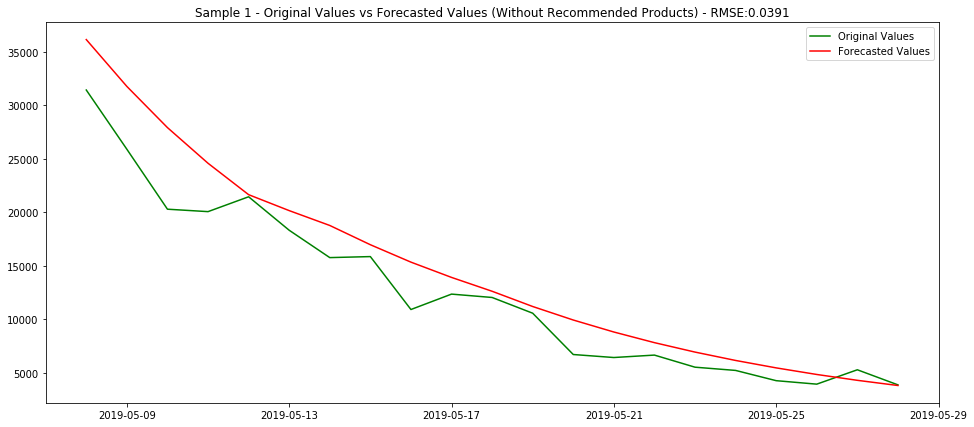

In [66]:
original_ts = sample_train_df1.iloc[sample_train_df1.index.isin(train.index)][['purchase_amount']]
original_ts = original_ts.append(sample_test_df1.iloc[sample_test_df1.index.isin(test.index)][['purchase_amount']])
print(original_ts.shape)

plt.figure(figsize=(16,7))
plt.plot(original_ts.index, original_ts, label='Original Values', color='green')
plt.plot(exp_forecast['ds'], exp_forecast['y_origin'].values, label='Forecasted Values', color='red')
plt.legend(loc='best')
plt.title("Sample 1 - Original Values vs Forecasted Values (Without Recommended Products) - RMSE:" + str(rmse))
plt.show()

In [106]:
test_ct = 7
daily_sales_increase = 0

original_ts = sample_train_df1.iloc[sample_train_df1.index.isin(train.index)][['purchase_amount']]
original_ts = original_ts.append(sample_test_df1.iloc[sample_test_df1.index.isin(test.index)][['purchase_amount']])
print(original_ts.shape)

exp_forecast['y_forecast'] = exp_forecast['y_origin']
forecast_ts_train = exp_forecast.head(n=latest_period)
forecast_ts_test = exp_forecast.tail(n=forecast_period)

for idx, r in recommended_products.iterrows():
    added_daily_sales = r['avg_daily_sales']
    forecast_ts_test['y_forecast'] += added_daily_sales
    
    daily_sales_increase += added_daily_sales
    
    if idx >= test_ct:
        break

(21, 1)


Total sales increased: 652.89


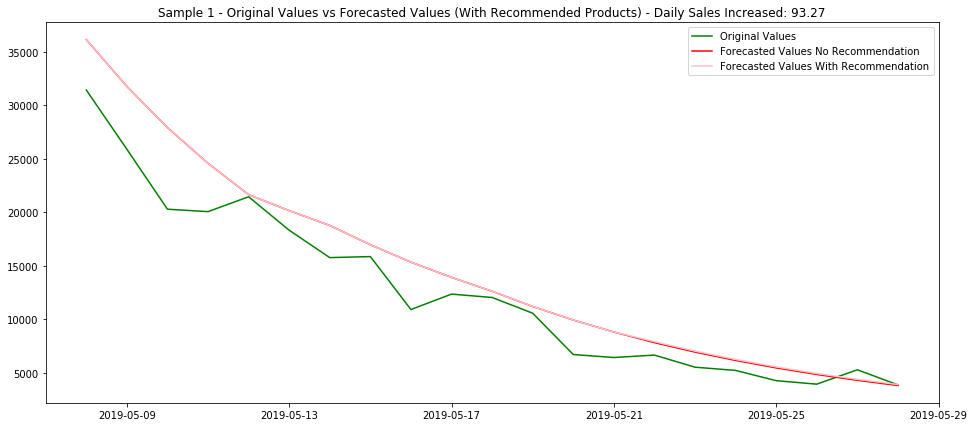

In [111]:
forecast_ts = forecast_ts_train.append(forecast_ts_test)
print('Total sales increased: ' + str(daily_sales_increase * forecast_period))

plt.figure(figsize=(16,7))
plt.plot(original_ts.index, original_ts, label='Original Values', color='green')
plt.plot(exp_forecast['ds'], exp_forecast['y_origin'].values, label='Forecasted Values No Recommendation', color='red')
plt.plot(forecast_ts['ds'], forecast_ts['y_forecast'].values, label='Forecasted Values With Recommendation', color='pink')
plt.legend(loc='best')
plt.title("Sample 1 - Original Values vs Forecasted Values (With Recommended Products) - Daily Sales Increased: " + str(daily_sales_increase))
plt.show()

## Note

* Later can divide merchants into groups based on the number of distinct product_ids. 
* For smaller merchants might need specific categories of recommendation.